# Number plate detector for russian plates using YOLO v8 and pytesseract

In [53]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np

from ultralytics import YOLO
from PIL import Image

# First step - download video/picture

In [54]:
# Downloading model
model = YOLO('/home/gor/Desktop/plates/models/yolov8x.pt')
# Downloading image
image = cv2.cvtColor(cv2.imread('/home/gor/Desktop/plates/1.jpeg'), cv2.COLOR_BGR2RGB)

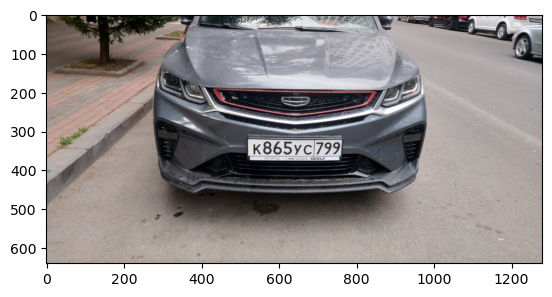

In [55]:
plt.imshow(image)

# Second step - make predictiion

In [56]:
# Make prediction
prediction = model.predict(image)


0: 320x640 5 cars, 663.3ms
Speed: 1.8ms preprocess, 663.3ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


In [57]:
"""
# Get new image with detected objects using torchvision


xy = []
for i in prediction[0].boxes:
    xy.append(i.xyxy)

torch_im = torchvision.io.read_image('/home/gor/Desktop/plates/1.jpeg')

for i in xy:
    torch_im = torchvision.utils.draw_bounding_boxes(
    image=torch_im,
    boxes=i,
    colors=(255,0,0),
    width=10
)
    
plt.imshow(torch_im.permute(1,2,0))
"""

"\n# Get new image with detected objects using torchvision\n\n\nxy = []\nfor i in prediction[0].boxes:\n    xy.append(i.xyxy)\n\ntorch_im = torchvision.io.read_image('/home/gor/Desktop/plates/1.jpeg')\n\nfor i in xy:\n    torch_im = torchvision.utils.draw_bounding_boxes(\n    image=torch_im,\n    boxes=i,\n    colors=(255,0,0),\n    width=10\n)\n    \nplt.imshow(torch_im.permute(1,2,0))\n"

# Step three - make mask (not so necessary)

In [58]:
# One more way to cut ROI
"""
masks_coordinates = []

for i in prediction[0].boxes:
    if i.cls==2:
        masks_coordinates.append(i.xyxy.numpy()[0])


pt1 = (masks_coordinates[0][0].astype('uint16'), masks_coordinates[0][1].astype('uint16'))
pt2 = (masks_coordinates[0][2].astype('uint16'), masks_coordinates[0][3].astype('uint16'))

mask = np.zeros(image.shape[:2], dtype='uint8')
mask = cv2.rectangle(
    img=mask,
    pt1=pt1,
    pt2=pt2,
    color=(255,0,0),
    thickness=-1
)
plt.imshow(mask)


cutted = cv2.bitwise_and(gray_im, gray_im, mask=mask)
plt.imshow(cutted)
"""

"\nmasks_coordinates = []\n\nfor i in prediction[0].boxes:\n    if i.cls==2:\n        masks_coordinates.append(i.xyxy.numpy()[0])\n\n\npt1 = (masks_coordinates[0][0].astype('uint16'), masks_coordinates[0][1].astype('uint16'))\npt2 = (masks_coordinates[0][2].astype('uint16'), masks_coordinates[0][3].astype('uint16'))\n\nmask = np.zeros(image.shape[:2], dtype='uint8')\nmask = cv2.rectangle(\n    img=mask,\n    pt1=pt1,\n    pt2=pt2,\n    color=(255,0,0),\n    thickness=-1\n)\nplt.imshow(mask)\n\n\ncutted = cv2.bitwise_and(gray_im, gray_im, mask=mask)\nplt.imshow(cutted)\n"

# Step four - cut detected object from image

confs - [0.950056791305542, 0.9004433751106262, 0.8429113030433655, 0.8326533436775208, 0.8045564293861389]
max_conf - 0
closest obj - [273.91162109375, 0.444122314453125, 985.383056640625, 467.6678771972656]


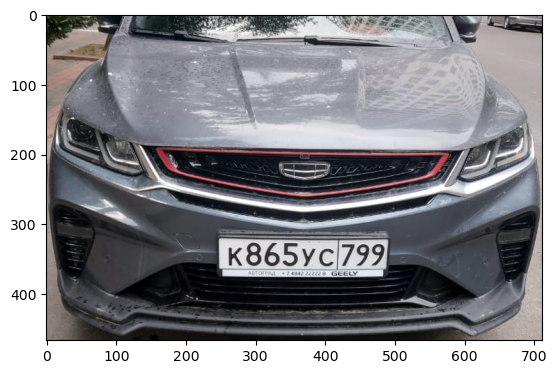

In [59]:
# List of objects' coordinates detected by model
obj_coords = []
for box in prediction[0].boxes:
    # Check whether class of detected object is 'car'
    if box.cls==2:
        obj_coords.append(box.xyxy.tolist()[0])

# Get list of confidentation values
confs = prediction[0].boxes.conf.tolist()
print(f'confs - {confs}')
# Get index of the most confident object
max_conf = confs.index(max(confs))
print(f'max_conf - {max_conf}')
# Get coordinates of this object
closest_obj = obj_coords[max_conf]
print(f'closest obj - {closest_obj}')
x1, y1, x2, y2 = int(closest_obj[0]), int(closest_obj[1]), int(closest_obj[2]), int(closest_obj[3])
obj_image = image[y1:y2, x1:x2]
plt.imshow(obj_image)

# Step five - detect plate

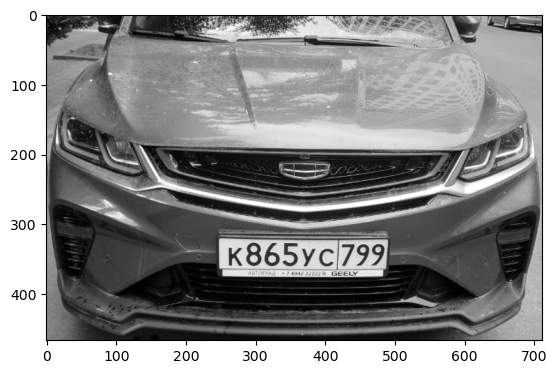

In [60]:
# Download haars' plate detector
plate_det = cv2.CascadeClassifier('/home/gor/Desktop/plates/models/haarcascade_russian_plate_number.xml')
# Turn the picture into gray scale
gray_cut = cv2.cvtColor(obj_image, cv2.COLOR_RGB2GRAY)
gray_cut = cv2.cvtColor(gray_cut, cv2.COLOR_BGR2RGB)
plt.imshow(gray_cut)

In [61]:
# Get plate using haars' detector
plate_coords = plate_det.detectMultiScale(gray_cut)[0]
x, y, w, h = plate_coords

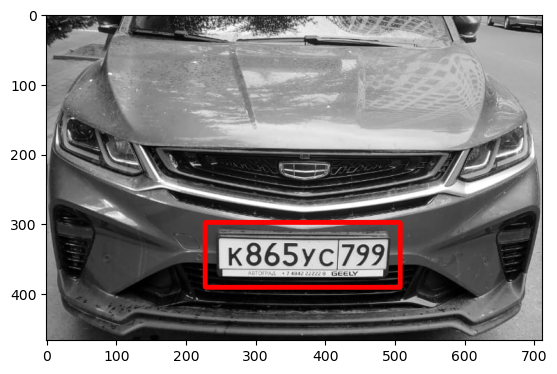

In [62]:
cv2.rectangle(gray_cut, (x,y), (x+w, y+h), color=(255,0,0), thickness=5)
plt.imshow(gray_cut)

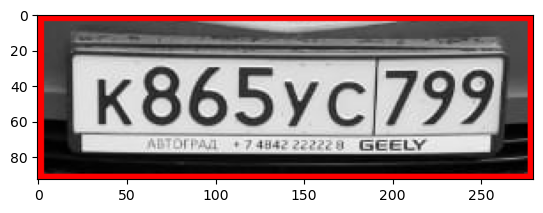

In [63]:
plate = gray_cut[y:y+h, x:x+w]
plt.imshow(plate)

# Step six - get plate's symbols

к865ус799



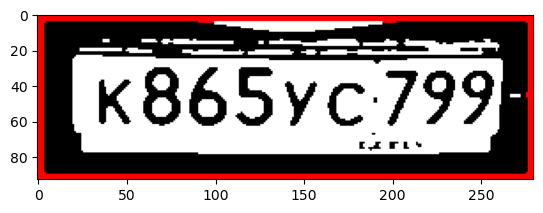

In [65]:
# Increasing contrast
ret, thresh = cv2.threshold(plate, 120, 255, cv2.THRESH_BINARY)
# blur the result picture
thresh = cv2.medianBlur(thresh, 3)
plt.imshow(thresh)

# Download image using Image from PIL (more friendly for pytesseract)
imm = Image.fromarray(thresh.astype(np.uint8))

plate_symbols = pytesseract.image_to_string(imm, lang='rus', config='--psm 7')
print(plate_symbols)